# Hand Landmark Model

จากโมเดลที่พัฒนาโดย Mediapipe ทำให้เราสามารถแสดงแบบจำลองของมือได้ โดยอาศัยการเรียนรู้ภาพต้นแบบสามมิติ จำนวน 30,000 ภาพ นำมาหาค่าพิกัดที่สำคัญ เพื่อใช้แสดงผลเป็นรูปทรงเรขาคณิตของมือจำนวน 21 พิกัด ดังรูป <br><br>

![hand_landmarks.png](https://mediapipe.dev/images/mobile/hand_landmarks.png)<br><br>

ในการนับจำนวนนิ้วที่ยกจะถูกแบ่งเป็น 2 ส่วน ได้แก่ นิ้วโป้งและสี่นิ้วที่เหลือ (นิ้วชี้,นิ้วกลาง,นิ้วนาง,และนิ้วก้อย)

1. **นิ้วโป้ง** ทำการวัดระยะทางระหว่างปลายนิ้วโป้ง (ตำแหน่งที่ 4) เทียบกับส่วนต้นข้อต่อนิ้วก้อย (ตำแหน่งที่ 17) เปรียบเทียบกับความกว้างของฝ่ามือ (ตำแหน่งที่ 5 กับ 17) ในกรณีที่ระยะห่างของปลายนิ้วโป้ง *มากกว่า* ความกว้างของฝ่ามือ *บวกกับ* ครึ่งนึงของระยะของหัวนิ้วโป้ง (ตำแหน่งที่ 3 กับ 4) จะถูกนับว่านิ้วโป้งถูกยกขึ้น

2. **สี่นิ้วที่เหลือ** ทำการวัดระยะทางระหว่างปลายนิ้วแต่ละนิ้ว (ตำแหน่งที่ 8, 12, 16, 20) เทียบกับข้อมือ (ตำแหน่งที่ 0) เปรียบเทียบกับข้อต่อส่วนปลายของแต่ละนิ้ว (ตำแหน่งที่ 7, 11, 15, 19) เที่ยบกับข้อมือ (ตำแหน่งที่ 0) ในกรณีที่ระยะห่างของปลายนิ้ว *มากกว่า* ข้อต่อส่วนปลายนิ้ว จะนับว่านิ้วนั้นถูกยกขึ้น

<br>

**ตัวอย่างโค้ด**ด้านล่าง จะเป็นการเขียนโปรแกรมเพื่อใช้งานตัวโมเดลจาก Mediapipe ในการทำนายจำนวนนิ้วที่นับ และแสดงผลเป็นรูปภาพพร้อมจุดพิกัดและเส้นเชื่อมแสดงรูปทรงเรขาคณิตของมือ โดยประกอบด้วย 5 ขั้นตอนดังต่อไปนี้

**ขั้นตอนที่ 1** การเชื่อมต่อ Google Drive เพื่อค้นหารูปภาพตัวอย่างที่เก็บอยู่ใน Drive ของคุณ

In [ ]:
# Connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**ขั้นตอนที่ 2** การนำเข้าโมเดลจาก Mediapipe

In [ ]:
import requests
import os
import tensorflow as tf

# Load the TFLite model and allocate tensors.
# Ref. https://google.github.io/mediapipe/solutions/models.html#hands

# URL of the TFLite model
model_url = "https://storage.googleapis.com/mediapipe-assets/hand_landmark_lite.tflite"

# Download the model
if not os.path.exists("hand_model.tflite"):
    response = requests.get(model_url)
    open("hand_model.tflite", "wb").write(response.content)

# Load the TFLite model
model = tf.lite.Interpreter(model_path="hand_model.tflite")
model.allocate_tensors()

# Get input and output tensors.
input_details = model.get_input_details()
output_details = model.get_output_details()

**ขั้นตอนที่ 3** นำเข้าและปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล

In [ ]:
import numpy as np
import cv2

# Path of the input image
image_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/hands/hand2.jpg"

# Load the image to predict
img = cv2.imread(image_path) # read image from path
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert an image to RGB color space
img = cv2.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][2])) # resize to match inputs of model
img = img / 255.0 # normalize image data
img = img.astype(np.float32)

**ขั้นตอนที่ 4** ประมวลผลรูปผ่านโมเดลเพื่อทำนายจุดพิกัดสำคัญของมือ

In [ ]:
# Pass the image and Run the model on the image
model.set_tensor(input_details[0]['index'], [img])
model.invoke()

# Get keypoints from the output
keypoints = model.get_tensor(output_details[0]['index'])
keypoints = np.squeeze(keypoints) # remove single-dimensional entries
keypoints = keypoints.reshape(-1, 3)[:, :-1] # reshape to (21, 2) only retrieve 'x' and 'y' axis

**ขั้นตอนที่ 5** แสดงผลรูปการทำนายมือพร้อมกับค่าจำนวนนิ้วที่นับได้

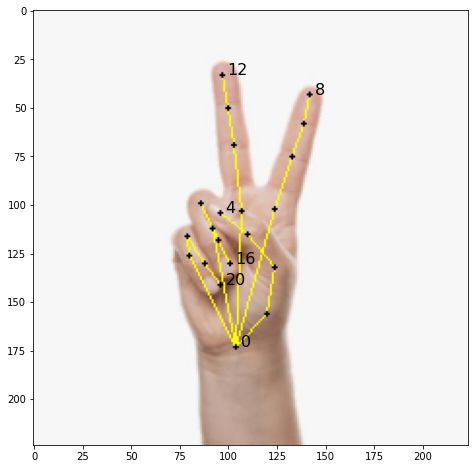

Number of fingers: 2


In [ ]:
from matplotlib import pyplot as plt

# Show the output image
if img[0,0,0] < 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(8, 8)) # define size of figure
plt.imshow(img) # display image in the figure

# Draw lines between keypoints
keypoints_pairs = [(0, 1), (1, 2), (2, 3), (3, 4), 
                   (0, 5), (5, 6), (6, 7), (7, 8), 
                   (0, 9), (9, 10), (10, 11), (11, 12), 
                   (0, 13), (13, 14), (14, 15), (15, 16), 
                   (0, 17), (17, 18), (18, 19), (19, 20)]
for pair in keypoints_pairs: # loop each key pair to draw line
    x1, y1 = int(keypoints[pair[0],0]), int(keypoints[pair[0],1])
    x2, y2 = int(keypoints[pair[1],0]), int(keypoints[pair[1],1])
    cv2.line(img, (x1, y1), (x2, y2), (255, 255, 0), 1) # draw a line

# Draw keypoints on the image
for i in range(keypoints.shape[0]): # loop all keypoints [0,1,2,...,20]
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    cv2.circle(img, kp, 1, (0, 0, 0), -1)

# Add text overlay on the image
for i in range(0, keypoints.shape[0], 4): # loop palm and only tips of each finger (0,4,8,12,16,20)
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    ax.annotate(i, kp, fontsize=16, xytext=(5,0), textcoords='offset points') # write text of keypoint ID

# Display the output image using matplotlib
plt.imshow(img)
plt.show()

# Number of Fingers Prediction
# Define the indices for keypoints for 4 fingers: Index, Middle, Ring, Pinky
# using palm, tips, and interphalangeal joints
palm = 0
tips = [8, 12, 16, 20]
joints = [6, 10, 14, 18]

# Check if 4 fingers are extended (except thumb)
# by calculate difference in distance between tips-to-palm and joint-to-palm
tips_distance = np.linalg.norm(keypoints[tips] - keypoints[palm], axis=1)
joints_distance = np.linalg.norm(keypoints[joints] - keypoints[palm], axis=1)
tips_joints_distance = tips_distance - joints_distance

# Check if thumb tip is extended using difference in distance between 
#    thumb tip (4) to pinky joint (17)
#    index tip (5) to pinky joint (17)
# And compare with
#    thumb tip (4) to thumb joint (3)
thumb_pinky = np.linalg.norm(keypoints[4] - keypoints[17])
index_pinky = np.linalg.norm(keypoints[5] - keypoints[17])
thumb_length = np.linalg.norm(keypoints[4] - keypoints[3])
thumb_distance = thumb_pinky - index_pinky

# Summarize number of fingers
fingers = (thumb_distance >= thumb_length/2) + sum(x >= 0 for x in tips_joints_distance)

# Print the number of fingers
print("Number of fingers:", fingers)